In [1]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = 255 - X_train
X_test = 255 - X_test

X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = X_train_flatten.astype('float32') / 255.
X_test_scaled = X_test_flatten.astype('float32') / 255.

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(60000, 784)
(10000, 784)


In [ ]:
# Upper bound

from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log_loss', max_iter=10000)
model.fit(X_train_scaled, y_train)

In [5]:
model.score(X_test_scaled, y_test)

0.9059

In [6]:
# Now, we don't have Y
import numpy as np
from sklearn.cluster import KMeans

k = 100
cluster = KMeans(n_clusters=k, random_state=42)
X_dist = cluster.fit_transform(X_train_scaled)

In [ ]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

labels = cluster.labels_
first10_clusters = np.unique(labels)[:10]

np.random.seed(42)
selected_idx = []
for c in first10_clusters:
    members = np.where(labels == c)[0]
    pick = np.random.choice(members, size=min(100, len(members)), replace=False)
    selected_idx.extend(pick)

X_picked = X_train_scaled[selected_idx] # for t-SNE input
images_picked = X_train[selected_idx] # for visualize
labels_picked = labels[selected_idx] # for coloring

tsne = TSNE(n_components=2, random_state=42)
X_2D = tsne.fit_transform(X_picked)

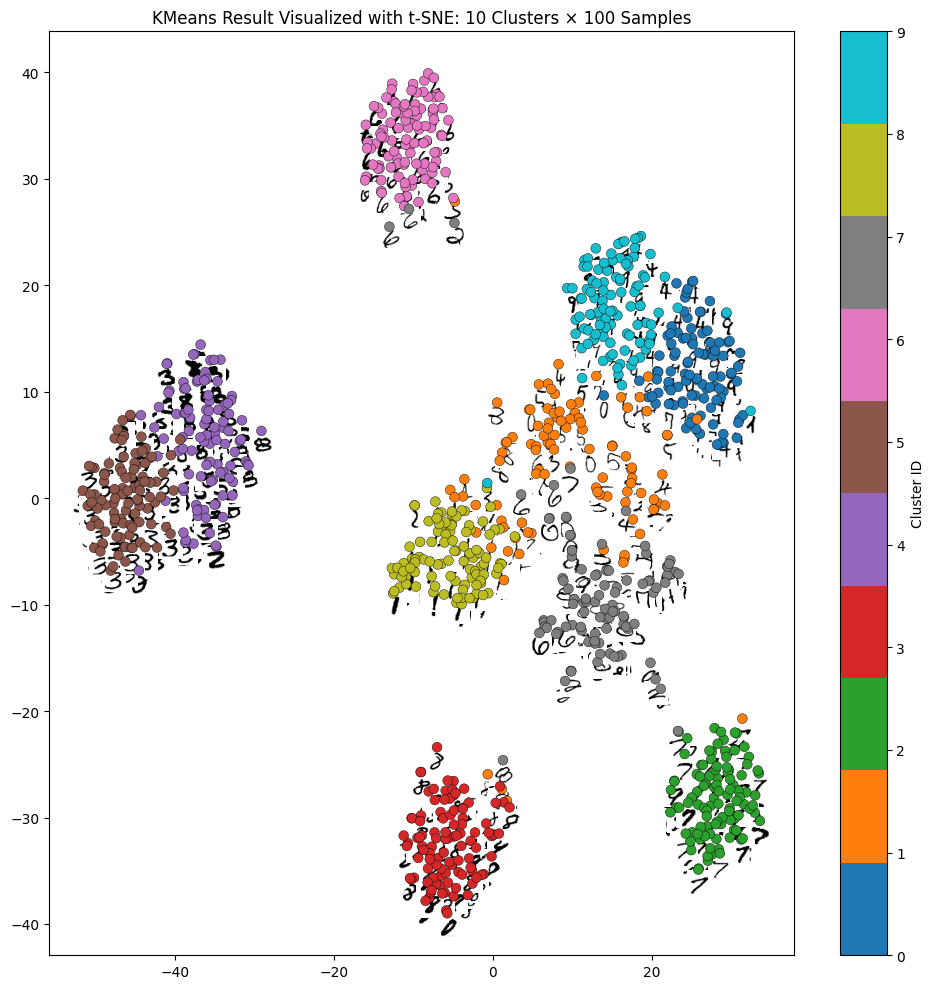

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

for (x, y), img in zip(X_2D, images_picked):
    im = OffsetImage(img, zoom=0.6, cmap='gray')
    ab = AnnotationBbox(
        im, (x, y), 
        xybox=(0, -10),
        boxcoords="offset points",
        frameon=False,
        zorder=1 # z-axis order
    )
    ax.add_artist(ab)

scatter = ax.scatter(
    X_2D[:,0], X_2D[:,1],
    c=labels_picked, cmap='tab10',
    s=50, edgecolors='k', linewidths=0.3,
    zorder=2
)

plt.colorbar(scatter, ticks=first10_clusters, label='Cluster ID')
plt.title('KMeans Result Visualized with t-SNE: 10 Clusters × 100 Samples')
plt.tight_layout()
plt.show()


In [ ]:
representative_idx = np.argmin(X_dist, axis=0) # for each cluster k
X_repr = X_train_scaled[representative_idx]

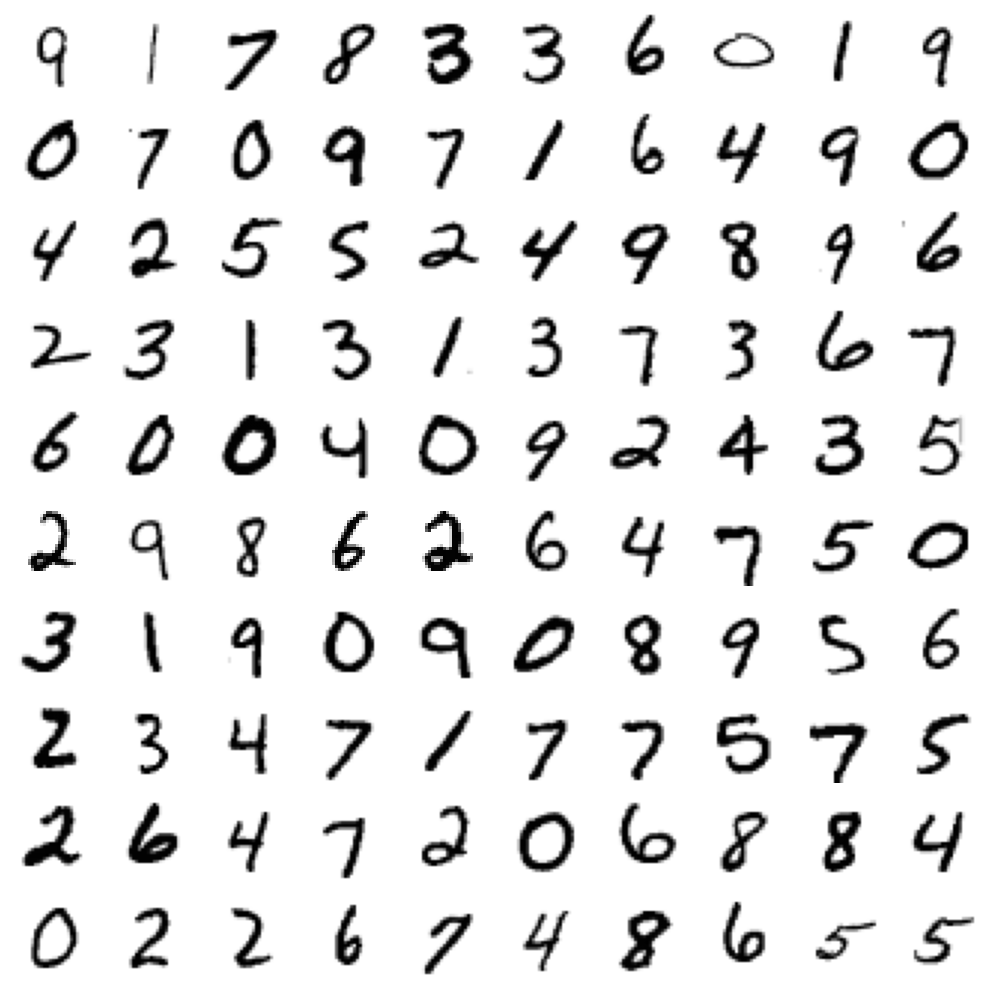

In [ ]:
rep_images = X_train[representative_idx]

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(rep_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
y_repr = [9, 1, 7, 8, 3, 3, 6, 0, 1, 9,
          0, 7, 0, 9, 7, 1, 6, 4, 9, 0,
          4, 2, 5, 5, 2, 4, 9, 8, 9, 6,
          2, 3, 1, 3, 1, 3, 7, 3, 6, 7,
          6, 0, 0, 9, 0, 9, 2, 4, 3, 5,
          2, 9, 8, 6, 2, 6, 4, 7, 5, 0,
          3, 1, 9, 0, 9, 0, 8, 9, 5, 6,
          2, 3, 4, 7, 1, 7, 7, 5, 7, 5,
          2, 6, 4, 7, 2, 0, 6, 8, 8, 4,
          0, 2, 2, 6, 7, 4, 8, 6, 5, 5]

In [ ]:
# 추가 학습이 아님, 아까 했던 건 아무거나 골라서 학습시켰을 때,
# 이건 k=100 clustering 후 centroid에 가까운 k개 sample만 뽑아서 representative images 100개로만 학습시키는 것
model = LogisticRegression(max_iter=10000)
model.fit(X_repr, y_repr)

LogisticRegression(max_iter=10000)

In [ ]:
model.score(X_test_scaled, y_test)

0.8211

In [ ]:
# Further step: Label Propagation
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[cluster.labels_ == i] = y_repr[i]

# k개의 cluster에 직접 labeling한 y값을 이용하여, 각 샘플이 속한 cluster 번호가 i번에 속하는 것들은,
# 직접 라벨링한 y_repr의 값을 통해 한 번에 할당

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled, y_train_propagated)

LogisticRegression(max_iter=10000)

In [ ]:
model.score(X_test_scaled, y_test)

0.8585

In [ ]:
# Further step: 각 cluster의 centroid에서 먼 1% sample을 anomaly로 간주하고 배제하여 train
normal_percent = 99

X_cluster_dist = X_dist[np.arange(len(X_train_scaled)), cluster.labels_]
# 각 샘플이 속한 centroid까지의 distsance
for i in range(k):
    in_cluster = (cluster.labels_ == i) # i번 cluster에 속하는 것들만
    centroid_dist = X_cluster_dist[in_cluster] # i번 cluster에 속하는 sample의 cnetroid까지의 distance
    above_cutoff = (X_cluster_dist > np.percentile(centroid_dist, normal_percent)) # 상위 99%
    X_cluster_dist[in_cluster & above_cutoff] = -1 # i번 cluster에 속하는데, cutoff를 초과한 애들 -1 (걸러내기 위함)

partial_idx = (X_cluster_dist != -1)
X_train_scaled_parital = X_train_scaled[partial_idx]
y_train_partial = y_train_propagated[partial_idx]

In [ ]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled_parital, y_train_partial)

MemoryError: Unable to allocate 355. MiB for an array with shape (59355, 784) and data type float64

In [ ]:
model.score(X_test_scaled, y_test)

0.8561

In [ ]:
import joblib